## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?

### Ответ

__Отличаются причины и следствия подобия и различия Item-Item и User-User:__
<br>Товары группируются в категории по назначению (машины, одежда, недвижимость), в ценовые группы (бюджетные, премиальные), в группы по бренду производителя (Различные бренды или noname), удерживающие рынок или начинающие продвижение и т.д. и т.п. Также и потребители группировка по полу, возрасту, семейному положению, по социальным и географическим признакам, отношение к разным моделям потребительского поведения и т.д.
<br>А подобными в Item-Item и User-User являются методы обработки после преобразования в векторы - эмбеддинги.
<br>Можно применять и к Item-Item и к User-User одни функции. Достаточно транспонировать матрицу.

Принципиальное отличие в том, что детерминированные алгоритмы используют группировку в духе KNN с нахождением подобных. 
<br>ALS итеративный метод на основе градиентного спуска с обучением коэффициентов (в данном случае эмбеддингов) в зависимости от функции ошибок.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 

### Ответ

- Даты взаимодействий
- Количество потребителей у товара
- Количество и величина чеков у потребителя

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

### Ответ

Настраиваимыми параметрами являются эмбеддинги - вектора в n-мерном векторном пространстве (на вебинаре была размернось 100). Соответственно это числовые вещественные значения. Зависимость факторов, вероятно, нелинейная. Функция ошибок непрерывная, выпуклая, дифференцируемая.

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

### Ответ

__Okapi BM25__ (best match) — поисковая функция на неупорядоченном множестве термов («мешке слов») и множестве документов, которые она оценивает на основе встречаемости слов запроса в каждом документе, без учёта взаимоотношений между ними (например, близости). Это не одна функция, а семейство функций с различными компонентами и параметрами.

Основана на эмпирических данных при попытке улучшить результаты работы критерия TF-IDF. Наилучшее соответствие между ожидаемым результатом и рассчитанным показал 25 алгоритм в списке, за что и получил свое название «Best matching», или BM25.

Суть функции заключается в определении релевантности документа к поисковому запросу. Т. е. документ анализируется, значения проставляются в формулу, где идет расчет относительно других документов в коллекции и выдается некая конечная оценка, которая влияет на ранжирование документа в поисковой выдаче.

Сама функция носит название BM25 (BM от англ. best match), но её часто называют «Okapi BM25» по названию поисковой системы Okapi, созданной в Лондонском городском университете в 1980-х и 1990-х годах, в которой эта функция была впервые применена.

<img src="image01.png">
IDF (qi) представляет из себя обратную документную частоту слова qi. В классическом варианте в BM25 она определяется так:
<img src="image02.png">
f (qi, D) это частота слова qi в документе D, |D| является длиной документа (рассчитывается из количества в нем слов). avgdl — это средняя длина документа в коллекции. k1 и b — это свободные коэффициенты, зачастую выбирают как k1 = 2.0 и b = 0.75.

В функцию БМ25 внедрены свободные коэффициенты, которые могут принимать различные значения. Они подбираются так, чтобы «подогнать» результат работы поиска под заранее имеющиеся данные. Документы сначала оценивают асессоры, которые и говорят что плохо, а что хорошо. Затем на основании этих данных выбирают упомянутые коэффициенты, чтобы расположить документы так же, как это сделали асессоры – так называемый «принцип обезьянки».

Чаще применяются «сглаженные» варианты этой формулы, например:
<img src="image03.png">
При экстремальных значениях коэффициента b в функции BM25 получаются функции ранжирования, известные под названиями BM11 (при b=1) и BM15 (при b=0)

### Процентный рост BM25 от числа вхождений

<img src="image04.png">

<img src="image05.png">

Источники:
1. http://www.staff.city.ac.uk/~sbrp622/papers/foundations_bm25_review.pdf
2. http://webline.blog/algoritm-okapi-bm25-modifikacziya-formuly-tf-idf-ranzhirovaniya-dokumentov/
3. https://ru.wikipedia.org/wiki/Okapi_BM25

## Практическая часть


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from time import time

In [2]:
data = pd.read_csv('./sem_2/retail_train.csv')   # '../data/transaction_data.csv'

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                     'product_id': 'item_id'},
            inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] <  data['week_no'].max() - test_size_weeks]
data_test  = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0)

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,...,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
user_item_matrix_val = pd.pivot_table(data_test, 
                                      index='user_id', 
                                      columns='item_id', 
                                      values='quantity', # Можно пробовать другие варианты
                                      aggfunc='count', 
                                      fill_value=0)

user_item_matrix_val = user_item_matrix_val.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item_val = csr_matrix(user_item_matrix_val).tocsr()

user_item_matrix_val.head(3)

item_id,29512,30356,32392,32439,34873,40405,42852,43094,44049,44522,...,17959192,17959243,17959460,17974316,17974317,17991689,17991691,18000012,18024155,18024556
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [6]:
def precision_at_k_l(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [7]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [23]:
def get_precision_at_k_score(result, user_item_matrix, name, iterat=15, fact=100, regularizat=0.001):
    
    time_begin = time()
    
    model = AlternatingLeastSquares(factors=fact, 
                                    regularization=regularizat,
                                    iterations=iterat, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=False)

    result[name] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    score = result.apply(lambda row: precision_at_k_l(row[name], row['actual']), axis=1).mean()
    
    time_finish = time()
    
    return score, time_finish-time_begin, model

In [9]:
import warnings
warnings.filterwarnings("ignore")

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

In [10]:
prec_5 = {}

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


#### Случайные веса

In [24]:
def set_random_weight(user_item_matrix):
    weights = np.random.rand(user_item_matrix.shape[0], user_item_matrix.shape[1])
    return user_item_matrix*weights

In [25]:
for i in range(1, 4):
    name = "rand_"+str(i)
    prec_5[name], time_len, _ = get_precision_at_k_score(result, set_random_weight(user_item_matrix), name, iterat=50)
    print(f"ALS {name}: {prec_5[name]:.4f} длительность: {time_len:.4f} c")

ALS rand_1: 0.1708 длительность: 314.9650 c
ALS rand_2: 0.1703 длительность: 304.5167 c
ALS rand_3: 0.1682 длительность: 260.1120 c


#### Логарифмические веса

In [26]:
w_m = set_random_weight(user_item_matrix)

w_m = np.log(w_m[w_m > 0])

In [27]:
w_m = w_m.fillna(0.0)

In [28]:
name = "log"

prec_5[name], time_len, _ = get_precision_at_k_score(result, w_m, name, iterat=50)
f"ALS log: {prec_5['log']:.4f} длительность: {time_len:.4f} c"

'ALS log: 0.1254 длительность: 271.3437 c'

#### TF-IDF взвешивание

In [29]:
name = "tfidf"
user_item_matrix_tfidf = tfidf_weight(user_item_matrix.T).T

prec_5[name], time_len, _ = get_precision_at_k_score(result, user_item_matrix_tfidf, name, iterat=50)
f"ALS tfidf: {prec_5['tfidf']:.4f} длительность: {time_len:.4f} c"

'ALS tfidf: 0.2269 длительность: 253.7911 c'

#### BM25 взвешивание

In [30]:
name = "bm25"
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T

prec_5[name], time_len, _ = get_precision_at_k_score(result, user_item_matrix_bm25, name, iterat=50)
f"ALS bm25: {prec_5['bm25']:.4f} длительность: {time_len:.4f} c"

'ALS bm25: 0.2167 длительность: 247.7284 c'

#### Список результатов

In [31]:
for k, v in dict(sorted(prec_5.items(), key=lambda item: item[1])).items():
    print(f"Precision@5: {v:0.4f} - ALS {k}")

Precision@5: 0.1254 - ALS log
Precision@5: 0.1682 - ALS rand_3
Precision@5: 0.1703 - ALS rand_2
Precision@5: 0.1708 - ALS rand_1
Precision@5: 0.2167 - ALS bm25
Precision@5: 0.2269 - ALS tfidf


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [33]:
summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0]], 
                            columns=['factors', 'regularization', 'iterations', 'time', 'precision@5_train', 'precision@5_valid'])
cnt = 0
factors = [50, 100, 150]
regularization = [0.01, 0.001, 0.0001]
iterations = [15, 50, 100]

for fact in factors:
    for reg in regularization:
        for iterat in iterations:
            name = f"ALS_{fact}_{reg}_{iterat}"
            print(f"ALS: factors {fact}, regularization {reg}, iterations {iterat}")
            score_train, time_len, model = get_precision_at_k_score(result, user_item_matrix, name, iterat=50)
            print(f"   Precision@5: {score_train:0.4f}, длительность: {time_len:.4f} c\n\n")
            summary_data.loc[cnt, ['factors', 'regularization', 'iterations', 
                                   'time', 'precision@5_train', 'precision@5_valid']] = [fact, reg, iterat, 
                                                                    time_len, score_train, score_train]
            cnt += 1

ALS: factors 50, regularization 0.01, iterations 15

Precision@5: 0.1894, длительность: 253.4302 c


ALS: factors 50, regularization 0.01, iterations 50

Precision@5: 0.1851, длительность: 255.1774 c


ALS: factors 50, regularization 0.01, iterations 100

Precision@5: 0.1875, длительность: 251.6525 c


ALS: factors 50, regularization 0.001, iterations 15

Precision@5: 0.1901, длительность: 253.9966 c


ALS: factors 50, regularization 0.001, iterations 50

Precision@5: 0.1882, длительность: 252.0370 c


ALS: factors 50, regularization 0.001, iterations 100

Precision@5: 0.1849, длительность: 251.8795 c


ALS: factors 50, regularization 0.0001, iterations 15

Precision@5: 0.1872, длительность: 252.0605 c


ALS: factors 50, regularization 0.0001, iterations 50

Precision@5: 0.1874, длительность: 253.0826 c


ALS: factors 50, regularization 0.0001, iterations 100

Precision@5: 0.1872, длительность: 252.2986 c


ALS: factors 100, regularization 0.01, iterations 15

Precision@5: 0.1886, длит

In [34]:
summary_data

,factors,regularization,iterations,time,precision@5_train,precision@5_valid
0,50.0,0.0100,15.0,253.430185,0.189422,0.189422
1,50.0,0.0100,50.0,255.177359,0.185113,0.185113
2,50.0,0.0100,100.0,251.652526,0.187463,0.187463
3,50.0,0.0010,15.0,253.996565,0.190108,0.190108
4,50.0,0.0010,50.0,252.037033,0.188247,0.188247
5,50.0,0.0010,100.0,251.879492,0.184917,0.184917
6,50.0,0.0001,15.0,252.060497,0.187169,0.187169
7,50.0,0.0001,50.0,253.082612,0.187365,0.187365
8,50.0,0.0001,100.0,252.298551,0.187169,0.187169
9,100.0,0.0100,15.0,256.579413,0.188639,0.188639


In [35]:
summary_data.sort_values('precision@5_valid', ascending=False)

,factors,regularization,iterations,time,precision@5_train,precision@5_valid
11,100.0,0.0100,100.0,252.703472,0.191185,0.191185
3,50.0,0.0010,15.0,253.996565,0.190108,0.190108
0,50.0,0.0100,15.0,253.430185,0.189422,0.189422
13,100.0,0.0010,50.0,252.794398,0.189226,0.189226
24,150.0,0.0001,15.0,257.894738,0.189030,0.189030
9,100.0,0.0100,15.0,256.579413,0.188639,0.188639
4,50.0,0.0010,50.0,252.037033,0.188247,0.188247
10,100.0,0.0100,50.0,252.908862,0.187855,0.187855
21,150.0,0.0010,15.0,252.732825,0.187757,0.187757
12,100.0,0.0010,15.0,252.950586,0.187659,0.187659


In [45]:
sorted_scores = summary_data.sort_values('precision@5_valid', ascending=True)['precision@5_valid'].values
sorted_times = summary_data.sort_values('precision@5_valid', ascending=True).time.values
sorted_times

array([252.12831974, 252.44515133, 251.87949228, 255.17735863,
       252.88938117, 253.09402227, 252.30329227, 252.14775538,
       252.30816793, 252.73053098, 252.29855084, 252.06049657,
       253.42430449, 253.08261156, 251.65252638, 260.06901336,
       252.98867416, 252.95058584, 252.73282504, 252.90886188,
       252.03703284, 256.57941341, 257.8947382 , 252.79439831,
       253.43018508, 253.9965651 , 252.7034719 ])

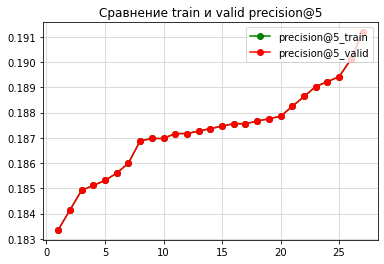

In [46]:
plt.plot(np.arange(1, len(sorted_scores)+1), sorted_scores, 'go-', label='precision@5_train')
plt.plot(np.arange(1, len(sorted_scores)+1), sorted_scores, 'ro-', label='precision@5_valid')

plt.legend(loc="upper right")
plt.grid(color="lightgrey")
plt.title('Сравнение train и valid precision@5')
plt.show()

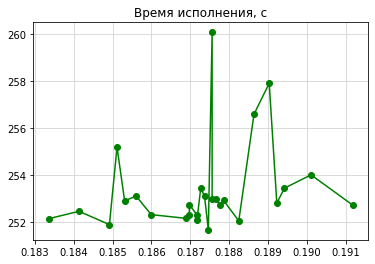

In [51]:
plt.plot(sorted_scores, sorted_times, 'go-')

plt.grid(color="lightgrey")
plt.title('Время исполнения, с')
plt.show()

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

## Выводы